In [1]:
import os
import torch

import scanpy as sc
import numpy as np
import pandas as pd
import gseapy as gp

from tqdm import tqdm
from sklearn.cluster import KMeans
from contrastive_vi.model.contrastive_vi import ContrastiveVIModel
from scripts import constants
from scvi._settings import settings
import logging

Global seed set to 0


In [2]:
settings.seed = 0
settings.verbosity = logging.CRITICAL
device = "cuda:1"
datasets = ["zheng_2017", "haber_2017", "mcfarland_2020", "norman_2019"]

Global seed set to 0


In [3]:
seeds = constants.DEFAULT_SEEDS
latent_size = 10

In [6]:
from collections import defaultdict

contrastiveVI_background_imputed_total = defaultdict(list)
contrastiveVI_target_imputed_total = defaultdict(list)
scVI_background_imputed_total = defaultdict(list)
scVI_target_imputed_total = defaultdict(list)

for dataset in datasets:
    split_key = constants.DATASET_SPLIT_LOOKUP[dataset]["split_key"]
    background_value = constants.DATASET_SPLIT_LOOKUP[dataset]["background_value"]
    label_key = constants.DATASET_SPLIT_LOOKUP[dataset]["label_key"]
    
    adata = sc.read_h5ad(
        os.path.join(
            constants.DEFAULT_DATA_PATH,
            f"{dataset}/preprocessed/adata_top_2000_genes_tc.h5ad",
        )
    )
    ContrastiveVIModel.setup_anndata(adata, layer="count")

    target_indices = np.where(adata.obs[split_key] != background_value)[0]
    target_adata = adata[target_indices]
    background_indices = np.where(adata.obs[split_key] == background_value)[0]
    background_adata = adata[background_indices]


    contrastiveVI_model_list = []
    scVI_model_list = []
    for seed in tqdm(seeds[:2]):
        result_dir = os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            f"{dataset}/contrastiveVI/latent_{latent_size}",
            f"{seed}",
        )
        contrastiveVI_model_list.append(
            torch.load(
                os.path.join(result_dir, "model.ckpt"),
                map_location=device,
            ),
        )

        scvi_result_dir = os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            f"{dataset}/scVI_with_background/latent_{latent_size}",
            f"{seed}",
        )

        scVI_model_list.append(
            torch.load(
                os.path.join(scvi_result_dir, "model.ckpt"),
                map_location=device,
            ),
        )
    
    contrastiveVI_background_imputed_list = [
        model.get_normalized_expression(background_adata, n_samples=100)["background"].values for model in tqdm(contrastiveVI_model_list)]
    contrastiveVI_target_imputed_list = [
        model.get_normalized_expression(target_adata, n_samples=100)["salient"].values for model in tqdm(contrastiveVI_model_list)]
    contrastiveVI_background_imputed_total[dataset] = contrastiveVI_background_imputed_list
    contrastiveVI_target_imputed_total[dataset] = contrastiveVI_target_imputed_list
    
    scVI_background_imputed_list = [
        model.get_normalized_expression(background_adata, n_samples=100).values for model in tqdm(scVI_model_list)]
    scVI_target_imputed_list = [
        model.get_normalized_expression(target_adata, n_samples=100).values for model in tqdm(scVI_model_list)]

    scVI_background_imputed_total[dataset] = scVI_background_imputed_list
    scVI_target_imputed_total[dataset] = scVI_target_imputed_list

100%|███████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:13<00:00,  6.79s/it]
/homes/gws/ewein/miniconda3/envs/contrastiveVI/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
100%|███████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:32<00:00, 46.07s/it]


In [5]:
from sklearn.metrics import mean_absolute_error

metric = mean_absolute_error

scVI_vs_scVI_background = defaultdict(list)
contrastiveVI_vs_scVI_background = defaultdict(list)
scVI_vs_scVI_target = defaultdict(list)
contrastiveVI_vs_scVI_target = defaultdict(list)

for dataset in datasets:
    scVI_background_adata_reference = scVI_background_imputed_total[dataset][0]
    scVI_background_adata_imputed = scVI_background_imputed_total[dataset][1]
    contrastiveVI_background_adata_imputed = contrastiveVI_background_imputed_total[dataset][1]
    
    scVI_target_adata_reference = scVI_target_imputed_total[dataset][0]
    scVI_target_adata_imputed = scVI_target_imputed_total[dataset][1]
    contrastiveVI_target_adata_imputed = contrastiveVI_target_imputed_total[dataset][1]
    
    for idx in tqdm(range(adata.shape[1])):
        scVI_vs_scVI_background[dataset].append(metric(
            scVI_background_adata_reference[:, idx], scVI_background_adata_imputed[:, idx]
        ))

        contrastiveVI_vs_scVI_background[dataset].append(metric(
            scVI_background_adata_reference[:, idx], contrastiveVI_background_adata_imputed[:, idx]
        ))
        
        scVI_vs_scVI_target[dataset].append(metric(
            scVI_target_adata_reference[:, idx], scVI_target_adata_imputed[:, idx]
        ))

        contrastiveVI_vs_scVI_target[dataset].append(metric(
            scVI_target_adata_reference[:, idx], contrastiveVI_target_adata_imputed[:, idx]
        ))

100%|████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 631.52it/s]


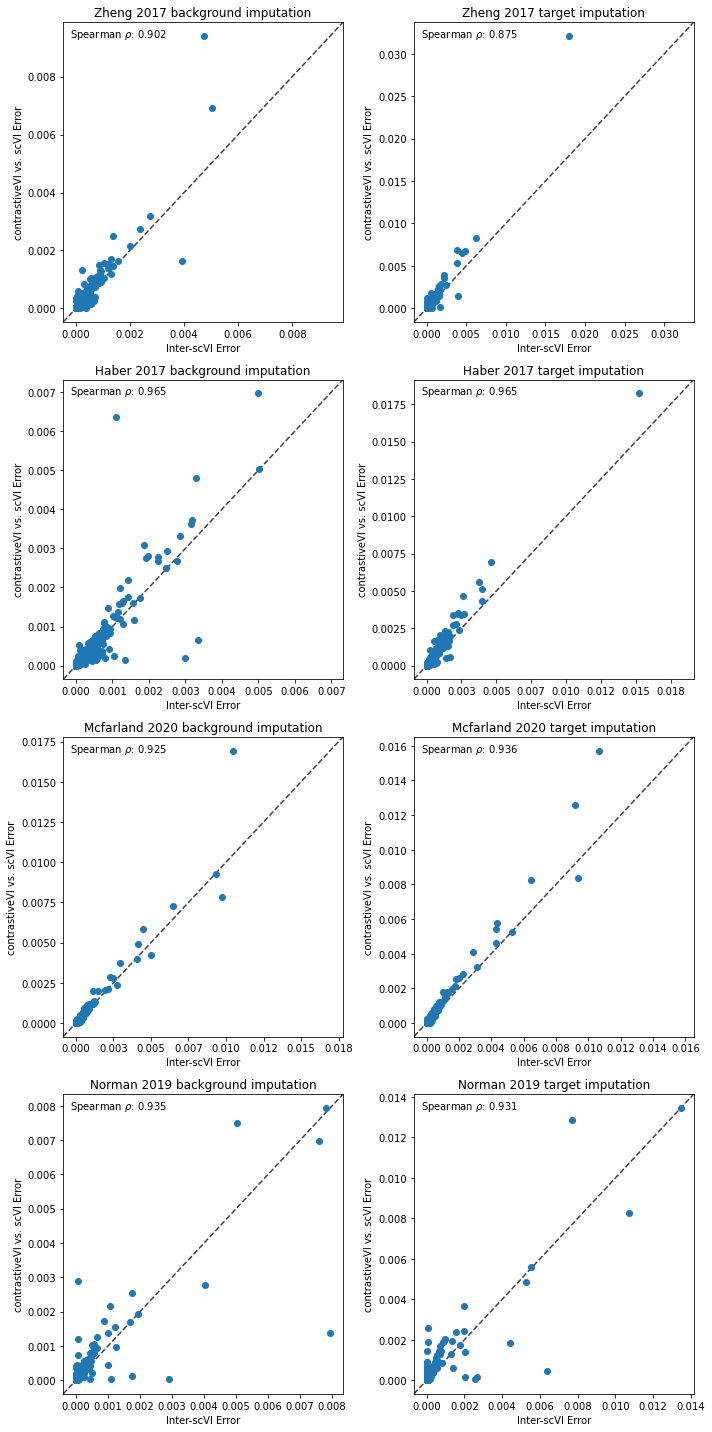

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from matplotlib.ticker import FormatStrFormatter

fig, axes = plt.subplots(len(datasets), 2, figsize=(10, len(datasets)*5))

for dataset, (ax1, ax2) in zip(datasets, axes):
    ax1.scatter(
        scVI_vs_scVI_background[dataset],
        contrastiveVI_vs_scVI_background[dataset]
    )
    
    dataset_name_formatted = dataset.replace('_', ' ').capitalize()

    ax1.set_ylabel("contrastiveVI vs. scVI Error")
    ax1.set_xlabel("Inter-scVI Error")

    ax1.set_title(f"{dataset_name_formatted} background imputation")

    lims = [
        np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
        np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
    ]
    ax1.set_xlim(lims)
    ax1.set_ylim(lims)

    ax1.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax1.annotate("Spearman $\\rho$: {:.3f}".format(
        spearmanr(scVI_vs_scVI_background[dataset], contrastiveVI_vs_scVI_background[dataset])[0]
    ), xy=(0.025, 0.95), xycoords='axes fraction')
    
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    ax2.scatter(
        scVI_vs_scVI_target[dataset],
        contrastiveVI_vs_scVI_target[dataset]
    )

    ax2.set_ylabel("contrastiveVI vs. scVI Error")
    ax2.set_xlabel("Inter-scVI Error")

    ax2.set_title(f"{dataset.replace('_', ' ').capitalize()} target imputation")

    lims = [
        np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
        np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
    ]
    ax2.set_xlim(lims)
    ax2.set_ylim(lims)

    ax2.plot(lims, lims, 'k--', alpha=0.75, zorder=0)

    ax2.annotate("Spearman $\\rho$: {:.3f}".format(
        spearmanr(scVI_vs_scVI_target[dataset], contrastiveVI_vs_scVI_target[dataset])[0]
    ), xy=(0.025, 0.95), xycoords='axes fraction')
    ax2.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))




plt.tight_layout()

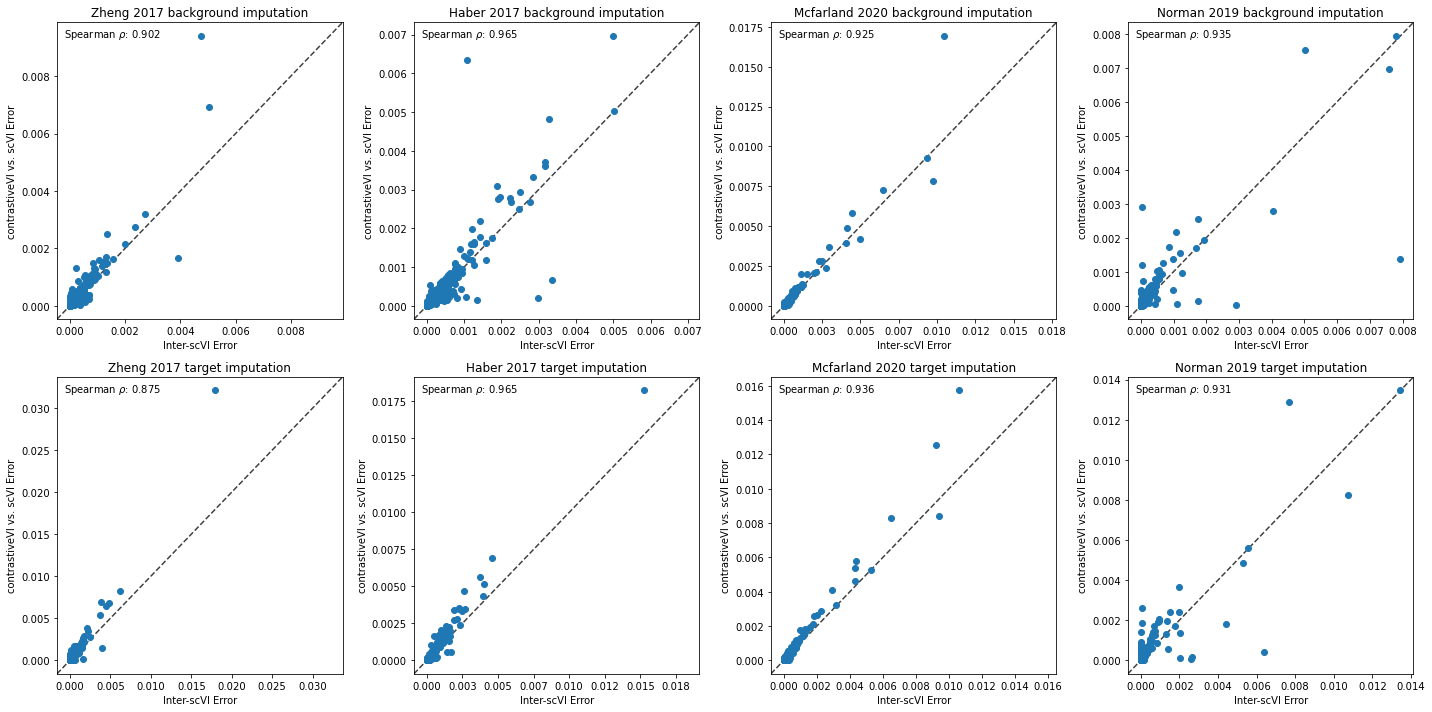

In [14]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from matplotlib.ticker import FormatStrFormatter

fig, (axes1, axes2) = plt.subplots(2, 4, figsize=(20, 10))

for dataset, ax in zip(datasets, axes1):
    ax.scatter(
        scVI_vs_scVI_background[dataset],
        contrastiveVI_vs_scVI_background[dataset]
    )
    
    dataset_name_formatted = dataset.replace('_', ' ').capitalize()

    ax.set_ylabel("contrastiveVI vs. scVI Error")
    ax.set_xlabel("Inter-scVI Error")

    ax.set_title(f"{dataset_name_formatted} background imputation")

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax.annotate("Spearman $\\rho$: {:.3f}".format(
        spearmanr(scVI_vs_scVI_background[dataset], contrastiveVI_vs_scVI_background[dataset])[0]
    ), xy=(0.025, 0.95), xycoords='axes fraction')
    
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

for dataset, ax in zip(datasets, axes2):
    ax.scatter(
        scVI_vs_scVI_target[dataset],
        contrastiveVI_vs_scVI_target[dataset]
    )
    
    dataset_name_formatted = dataset.replace('_', ' ').capitalize()

    ax.set_ylabel("contrastiveVI vs. scVI Error")
    ax.set_xlabel("Inter-scVI Error")

    ax.set_title(f"{dataset_name_formatted} target imputation")

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax.annotate("Spearman $\\rho$: {:.3f}".format(
        spearmanr(scVI_vs_scVI_target[dataset], contrastiveVI_vs_scVI_target[dataset])[0]
    ), xy=(0.025, 0.95), xycoords='axes fraction')
    
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.tight_layout()

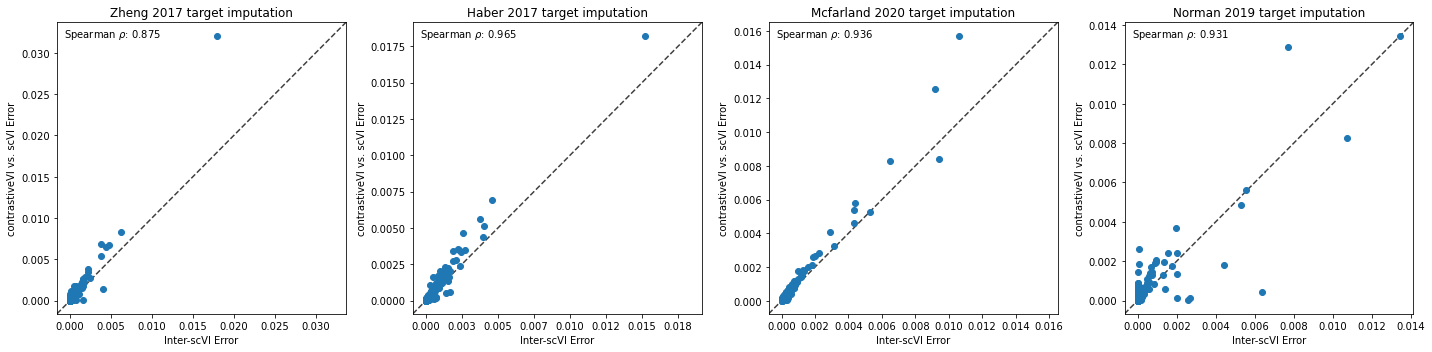

In [13]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from matplotlib.ticker import FormatStrFormatter

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for dataset, ax in zip(datasets, axes):
    ax.scatter(
        scVI_vs_scVI_target[dataset],
        contrastiveVI_vs_scVI_target[dataset]
    )
    
    dataset_name_formatted = dataset.replace('_', ' ').capitalize()

    ax.set_ylabel("contrastiveVI vs. scVI Error")
    ax.set_xlabel("Inter-scVI Error")

    ax.set_title(f"{dataset_name_formatted} target imputation")

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax.annotate("Spearman $\\rho$: {:.3f}".format(
        spearmanr(scVI_vs_scVI_target[dataset], contrastiveVI_vs_scVI_target[dataset])[0]
    ), xy=(0.025, 0.95), xycoords='axes fraction')
    
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.tight_layout()